In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys, csv, math
import inspect
import string 
import time
from itertools import chain
from collections import Counter
import networkx as nx
%matplotlib inline

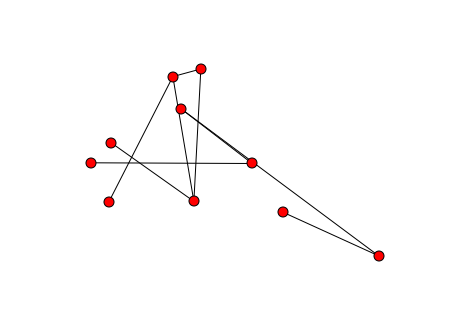

In [17]:
n=10

#On crée une matrice carrée de taille n dont les valeurs sont nulles
M=np.array([[0 for i in range(n)] for j in range(n)])

#On associe à chaque noeud i du réseau un nombre Ai distribué selon une loi de pareto
a, m=2, 1
F=np.around(np.random.pareto(a, n)+m)

#on crée une liste composée de Ai fois chaque entier i
L=list()
for i in range(n):
    L.append([i for el in range(int(F[i]))])
L=list(chain(*L))

#tirage aléatoire de paires sans remise jusqu'à épuisement du stock. A chaque fois que je tire une paire (i,j)
#je crée un edge entre les points i et j

while len(L)>1:
    s0=int(np.around(np.random.uniform(0, len(L)-1, 1)))
    Ls0=L[s0]
    L.remove(L[s0])
    
    s1=int(np.around(np.random.uniform(0, len(L)-1, 1)))
    Ls1=L[s1]
    L.remove(L[s1])
    
    M[Ls0, Ls1]+=1
    M[Ls1, Ls0]+=1

#on supprime les liens multiples et circulaires
M[M>1]==1
for i in range(n):
    M[i, i]=0
    
G=nx.from_numpy_matrix(M)
nx.draw_random(G, node_size=100)

 

In [3]:
#Verifions que le degré suit une loi de pareto
degdist=pd.DataFrame()
degdist['degree']=(nx.degree(G).values())
degdist['rank']=n-degdist['degree'].rank(method='first', ascending=True)
degdist['log_degree']=np.log(degdist['degree'])
degdist['log_rank']=np.log(degdist['rank'])

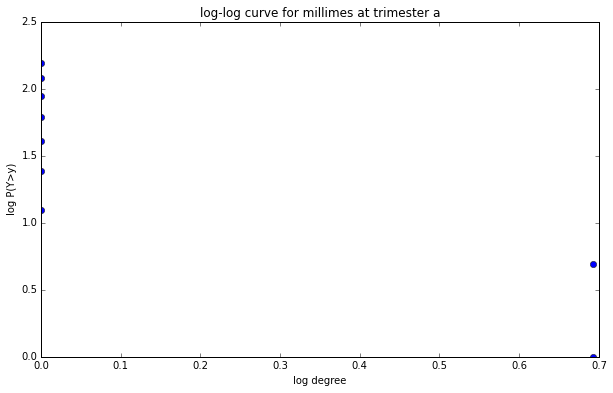

In [4]:
fig = plt.figure(figsize=(10,6))
plt.title("Log-log curves for the degree distribution")

ax=plt.subplot(1,1,1)
ax.set_title("log-log curve for millimes at trimester %x" %(i+1))
plt.ylabel("log P(Y>y)")
plt.xlabel("log degree")
ax.plot(degdist['log_degree'],degdist['log_rank'], 'bo')

plt.show()

In [5]:
degrees  = G.degree() 
# dictionary node:degree
in_values = (sorted(set(degrees.values())) )
in_hist = ([list(degrees.values()).count(x) for x in in_values])
in_hist = n-np.cumsum(in_hist)

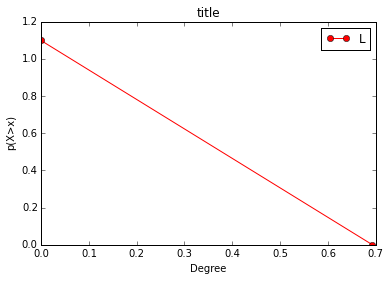

In [6]:
plt.figure()
plt.plot(np.log(in_values),np.log(in_hist),'ro-') 

# out-degree
plt.legend('Log-degree')
plt.xlabel('Degree')
plt.ylabel('p(X>x)')
plt.title('title')
plt.show()
plt.close()

In [7]:
# - trier en fonction du second élément du t-uple
# - supprimer les doublons en regard du premier élément

import pandas as pd

def supertri(d):
    t,i=d.columns
    d.sort(columns=t, inplace=True) 
    d=d.drop_duplicates(subset=i, take_last=False)
    return(d)

def next_step(d):
    n=d.shape[0]
    t,i=d.columns
    d=supertri(d)
    d.index = range(1,len(d) + 1)
    x=d.copy().loc[1]
    d[t]=d[t]-d[t][1]
    if n==1:
        d= pd.DataFrame(columns=["T","ind"])
    else:
        d=d.loc[2:]
    return([x, d])

d=pd.DataFrame([(6,2), (1, 1), (2, 3), (3, 3), (3, 4)],columns=["T","ind"])
supertri(d) 
next_step(d)[1].shape

C:\Users\Peter-Jack\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(3, 2)

In [8]:
## No vacination

import random

lamb=1  ## Plus il est grand et plus les gens se rencontrent fréquemment
gamma=.01 ## Plus il est petit et plus la personne est infectieuse longtemps

t=0
new_times=[]
i_0=random.randint(0, n)
V_0= np.array([0] * (i_0) + [1] + [0] * (n-i_0-1))
States=["S"] * (i_0) + ["I"] + ["S"] * (n-i_0-1)

while len(new_times)==0:
    I=random.expovariate(gamma)

    H_i = np.dot(V_0, M)
    ind_i=[i for i in range(n) if H_i[i]==1]
    n_i=np.sum(H_i)
    T_i=[random.expovariate(lamb) for i in range(n_i)]

    new_times=[[T_i[i],ind_i[i]] for i in range(n_i) if I>T_i[i]]
    

Infected=[-1] * (i_0-1) + [I] + [-1] * (n-i_0)

Results=[]
Results.append([t,1,0])
##time=0, 1 infected, 0 in remission


times=pd.DataFrame(new_times,columns=["T","ind"])
times=supertri(times)

def whichstate(x):
    if x>0:
        return("I")
    elif x==0:
        return("R")
    else:
        return("S")

i=0

while times.shape[0] != 0:
    i=i+1
##if True:    
    new_step=next_step(times)
    new_ind=int(new_step[0]["ind"])
    new_time=new_step[0]["T"]
    times=new_step[1]
    
    def retract(x):
        if x-new_time>0:
            return(x-new_time)
        elif x==-1:
            return(x)
        else:
            return(0)
    num=sum([i for i in range(n) if Infected[i]==new_time])
    Infected=list(map(retract,Infected))
    
    
    
    ##On trouve les nouveaux amis potentiellement infectable et on tire un nouveau I:
    I=random.expovariate(gamma)
    print(Infected)
    Infected[new_ind]=I
    States=list(map(whichstate,Infected))
    
    V_0= np.array([0] * new_ind + [1] + [0] * (n-new_ind-1))

    H_i = np.dot(V_0, M)
    ## On cheque que les potentiellement infectable puisse etre infecter    
    ind_i=[i for i in range(n) if (H_i[i]==1 and States[i]=="S")]
    
    ##On tire des temps pour ces amis
    n_i=len(ind_i)
    T_i=[random.expovariate(lamb) for i in range(n_i)]
   
    ##On ne garde que ceux qui sont inférieurs à I
    new_times=[[T_i[i],ind_i[i]] for i in range(n_i) if I>T_i[i]]
    if len(new_times)!=0:
        new_times=pd.DataFrame(new_times,columns=["T","ind"])

        ##On les rajoute à times que l'on update par la suite.
        times=pd.concat([times,new_times])
        ##On met à jour
        times=supertri(times)
    t=t+new_time
    Results.append([t,sum([1 for st in States if st=="I"]),sum([1 for st in States if st=="R"])])

t_0=t
num_I=sum([1 for st in States if st=="I"])
num_R=sum([1 for st in States if st=="R"])

last_moments=sorted([el for el in Infected if el>0])
last_moments_n=len(last_moments)
for i in range(last_moments_n):
    num_I=num_I-1
    num_R=num_R+1
    if i==0:
        t+=last_moments[i]
    else:
        t+=last_moments[i]-last_moments[i-1]
    Results.append([t,num_I,num_R])
R=np.matrix(Results)

[t_0,sum([1 for st in States if st=="I"]),sum([1 for st in States if st=="R"])]

    

          T  ind
0  0.089131    2
[17.290404145861011, -1, -1, -1, -1, -1, -1, -1, -1, -1]
          T  ind
0  2.397712    1
[14.892691766754806, -1, 111.87693671294744, -1, -1, -1, -1, -1, -1, -1]


[2.486843230567271, 3, 0]

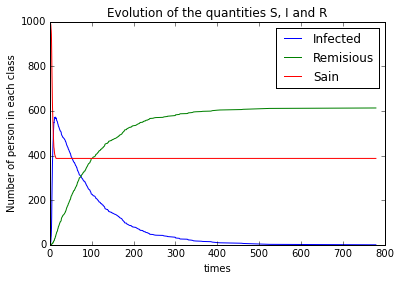

In [124]:
plt.figure()
first, =plt.plot(R[:,0],R[:,1])
second, =plt.plot(R[:,0],R[:,2]) 
third, =plt.plot(R[:,0],n-R[:,1]-R[:,2])

# out-degree
plt.legend([first,second,third],['Infected','Remisious','Sain'])
plt.xlabel('times')
plt.ylabel('Number of person in each class')
plt.title('Evolution of the quantities S, I and R')
plt.show()
plt.close()

In [109]:
print(Infected.sort(reverse=True))
Infected
[elt for elt in Infected if elt>0]


None


[61.168935286645812,
 38.662752933124104,
 35.003950170791221,
 33.835448626185261,
 32.867969371649643,
 32.347964679863161,
 31.817251082940736,
 29.03023662680534,
 28.473121695846011,
 28.376911517842153,
 27.211013787755199,
 26.729301990286316,
 26.218546029160265,
 26.106411059047886,
 24.353148631721091,
 24.243205305962675,
 23.159563541581356,
 22.817804666277603,
 22.688397362993825,
 22.524833010935247,
 22.00893793211322,
 21.723446837986415,
 21.252528576161879,
 20.577437996465385,
 20.377841854850011,
 20.316736286292034,
 20.172408378682164,
 19.520882356371999,
 19.384201149187845,
 18.943265983500375,
 18.902352628207325,
 18.653040484414838,
 18.468229716275971,
 18.047048523373064,
 17.913096624217566,
 17.876950806947455,
 17.550231967896252,
 17.35731983040175,
 17.163454455927301,
 17.013933854519273,
 16.272742399410092,
 15.919181785093222,
 15.816326829056621,
 15.622543411352531,
 15.545933071945484,
 15.484957711195703,
 14.852436380247697,
 14.729646123203

In [20]:

import pandas as pd

def supertri_bis(d):
    t,i,v=d.columns
    d.sort(columns=t, inplace=True) 
    d=d.drop_duplicates(subset=i, take_last=False)
    return(d)

def next_step_bis(d):
    n=d.shape[0]
    t,i,v=d.columns
    d=supertri_bis(d)
    d.index = range(1,len(d) + 1)
    x=d.copy().loc[1]
    d[t]=d[t]-d[t][1]
    if n==1:
        d= pd.DataFrame(columns=["T","ind","V"])
    else:
        d=d.loc[2:]
    return([x, d])

d=pd.DataFrame([(6,2,1), (1, 1,0), (2, 3,1), (3, 3,0), (5, 3,1)],columns=["T","ind","V"])
supertri_bis(d) 
next_step_bis(d)

C:\Users\Peter-Jack\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[T      1
 ind    1
 V      0
 Name: 1, dtype: int64,    T  ind  V
 2  1    3  1
 3  5    2  1]

In [29]:
## 1st vacination model


import random

lamb=1  ## Plus il est grand et plus les gens se rencontrent fréquemment
gamma=.01 ## Plus il est petit et plus la personne est infectieuse longtemps
theta=1 ## delay time
rho=0 ##probabilities of finding someone's friend


t=0
new_times=[]
i_0=random.randint(0, n)
V_0= np.array([0] * (i_0) + [1] + [0] * (n-i_0-1))
States=["S"] * (i_0) + ["I"] + ["S"] * (n-i_0-1)
## a new state appears, vaccinated



while len(new_times)==0:
    I=random.expovariate(gamma)
    S=random.expovariate(theta)

    H_i = np.dot(V_0, M)
    ind_i=[i for i in range(n) if H_i[i]==1]
    n_i=np.sum(H_i)
    T_i=[random.expovariate(lamb) for i in range(n_i)]
    
    proba=[1 if random.random()<rho else 0  for i in range (n_i)]
    mini=min(I,S)
    new_times=[]
    for i in range(n_i):
        if (mini>T_i[i] or (S<T_i[i] and T_i[i]<I and proba[i]==0)):
            new_times.append([T_i[i],ind_i[i],0])
        elif proba[i]==1:
            new_times.append([S,ind_i[i],1])

Infected=[-1] * (i_0-1) + [I] + [-1] * (n-i_0)
print(Infected)
Results=[]
Results.append([t,1,0,0])
Vacinated_hist=[]
##time=0, 1 infected, 0 in remission 0 yet vacinned


times=pd.DataFrame(new_times,columns=["T","ind","V"])
print("times")
print(times)
times=supertri_bis(times)

print("times")
print(times)

def whichstate(x):
    if x>0:
        return("I")
    elif x==-1: 
        return("R")
    elif x==-2:
        return("V")
    else:
        return("S")

i=0

while times.shape[0] != 0 and i<10:
    print("times")
    print(times)
    i=i+1
##if True:    
    new_step=next_step_bis(times)
    print("times without")
    times=new_step[1].copy
    print(times)
    
    new_ind=int(new_step[0]["ind"])
    new_time=new_step[0]["T"]
    profile=new_step[0]["V"]
    
    print("new_step")
    print(new_step[0])
    
    def retract(x):
            if x-new_time>0:
                return(x-new_time)
            elif x==-1: ##R
                return(x)
            elif x==-2: ##V
                return(x)
    num=sum([i for i in range(n) if Infected[i]==new_time])
    Infected=list(map(retract,Infected))
    t=t+new_time
    
    if profile == 0:

        ##On trouve les nouveaux amis potentiellement infectable et on tire un nouveau I:
        I=random.expovariate(gamma)
        S=random.expovariate(theta)

        Infected[new_ind]=I
        print(Infected)
        States=list(map(whichstate,Infected))

        V_0= np.array([0] * new_ind + [1] + [0] * (n-new_ind-1))

        H_i = np.dot(V_0, M)
        ## On cheque que les potentiellement infectable puisse etre infecter    
        ind_i=[i for i in range(n) if (H_i[i]==1 and States[i]=="S")]

        ##On tire des temps pour ces amis
        n_i=len(ind_i)
        T_i=[random.expovariate(lamb) for i in range(n_i)]
        proba=[1 if random.random()<rho else 0  for i in range (n_i)]

        ##On ne garde que ceux qui sont inférieurs à I
        for i in range(n_i):
            if (mini>T_i[i] or (S<T_i[i] and T_i[i]<I and proba[i]==0)):
                new_times.append([T_i[i],ind_i[i],0])
            elif proba[i]==1:
                new_times.append([S,ind_i[i],1])
        
        if len(new_times)!=0:
            new_times=pd.DataFrame(new_times,columns=["T","ind","V"])

            ##On les rajoute à times que l'on update par la suite.
            times=pd.concat([times,new_times])
            
            print("times1")
            print(times)
            ##On met à jour
            times=supertri_bis(times)
            
            print("times2")
            print(times)
        Results.append([t,sum([1 for st in States if st=="I"]),sum([1 for st in States if st=="R"]),sum([1 for st in States if st=="V"])])
    else:
        States[new_ind]="V"
        Vacinated_hist.append(t)
        Infected[new_ind]=-2

t_0=t
num_I=sum([1 for st in States if st=="I"])
num_R=sum([1 for st in States if st=="R"])

last_moments=sorted([el for el in Infected if el>0])
last_moments_n=len(last_moments)
for i in range(last_moments_n):
    num_I=num_I-1
    num_R=num_R+1
    if i==0:
        t+=last_moments[i]
    else:
        t+=last_moments[i]-last_moments[i-1]
    Results.append([t,num_I,num_R])
R=np.matrix(Results)

[t_0,sum([1 for st in States if st=="I"]),sum([1 for st in States if st=="R"])]


[-1, -1, -1, -1, -1, 40.81768716956502, -1, -1, -1, -1]
times
          T  ind  V
0  1.162476    0  0
1  0.497397    3  0
times
          T  ind  V
1  0.497397    3  0
0  1.162476    0  0
times
          T  ind  V
1  0.497397    3  0
0  1.162476    0  0
times without
<bound method DataFrame.copy of           T  ind  V
2  0.665078    0  0>
new_step
T      0.497397
ind    3.000000
V      0.000000
Name: 1, dtype: float64
[-1, -1, -1, 25.29177721890834, -1, 40.320289928532262, -1, -1, -1, -1]


TypeError: cannot concatenate a non-NDFrame object

In [18]:
M

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 0]])